# House Prices - Advanced Regression Techniques

<img src = 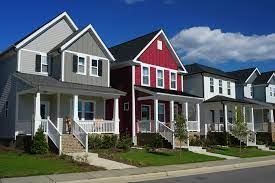 >

## Checklist:

O presente projeto está dividido em etapas, baseado no framework CRISP-DM, a fim de propor uma solução estruturada e condizente com desafios reais:  

1. Análise do problema e entendimento do panorama geral
2. Obtenção dos dados
3. Exploração dos dados 
4. Preparação dos dados
5. Modelagem - Treinamento e seleção de modelos
6. Aperfeiçoamento dos modelos e solução final
7. Apresentação da solução
8. Implementação, monitoramento e manutenção

### Setup and libraries

In [162]:
# !pip install feature-engine catboost lightgbm
# !pip install os
# !pip install pandas 
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# ! pip install ISLP


import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer


import statsmodels.api as sm

from ISLP.models import (ModelSpec as MS, summarize)

## 1. Análise do problema e panorama geral

Definição do problema: Utilizando variáveis explanatórias que descrevem aspectos de imóveis residenciais em Ames, Iowa, **o objetivo aqui é predizer o preço final de cada casa (em dólares).**  

Essas predições **podem ser usadas por pessoas ou empresas interessadas em comprar ou vender casas na região, como referência de preço.**

O problema será resolvido através de **técnicas de regressão (aprendizado supervisionado)**, utilizando como conjunto de treinamento casas cujos preços são conhecidos.  

A métrica de avaliação escolhida é a **raiz do erro quadrático médio (RMSE).** Essa escolha é para garantir que não estamos superestimando nem subestimando os preço das casas.

Uma **performance minimamente aceitável seria seria um RMSE abaixo de 10.000** (ou seja, errar o preço da casa em até 10 mil dólares para mais ou para menos).

## 2. Obtenção dos dados

Os dados desse desafio estão disponíveis em:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data  
  
Para evitar que sejam removidos/alterados, vamos trabalhar com uma cópia dos dados, armazenada na máquina local.  

Os arquivos disponíveis no Kaggle são:

a) train.csv - um arquivo com os dados para treinamento;  
b) test.csv - um arquivo com os dados para teste;  
c) data_description.txt - um arquivo com o dicionário de dados;  
d) sample_submission.csv - um arquivo de exemplo para submeter os resultados no Kaggle.




### 2.1 Carregando os dados de treinamento

In [163]:
diretorio = '/Users/diego/Library/CloudStorage/OneDrive-Pessoal/Documentos/Data Science/datasets/house-prices'
arquivo = 'train.csv'

df_raw = pd.read_csv(os.path.join(diretorio, arquivo))
df_raw.shape

(1460, 81)

Na base de dados, temos 1460 linhas (casas) e 81 colunas, que consistem em:  
- Uma variável de identificação do imóvel _(Id)_
- Uma variável com o preço de venda _(SalePrice)_, que será o target 
- E 79 variáveis referentes às características do imóvel, que serão as features

In [164]:
df_raw.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Antes de prosseguir com a exploração dos dados e com a modelagem, vamos dividir o conjunto de dados em duas partes: uma parte para treinamento e outra parte para testes.  
Dessa forma, evitamos qualquer tipo de vazamento de dados (data leakage).  
O conjunto de testes original (sem o target) será utilizado apenas para submeter os resultados na competição do Kaggle.

In [165]:
# Splitting data in train and test

X = df_raw
y = df_raw['SalePrice']

from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=True)

## 3. Exploração dos dados de treinamento

Inicialmente, vamos formular algumas perguntas sobre os dados de treinamento.

1) Quantas casas existem na base de dados?
2) Existem casas duplicadas na base de dados?
3) Qual é o preço médio das casas?
4) Qual é a casa mais cara e a casa mais barata da base de dados?
5) Qual é a casa mais nova e a casa mais velha da base?
6) Qual a venda mais recente e a venda mais antiga da base?

7) Temos valores faltantes na base de dados? Em quais características?



In [166]:
# Quantas casas existem na base de dados?

print(f"Existem {df_train['Id'].count()} casas na base de dados de treinamento.")

Existem 1021 casas na base de dados de treinamento.


In [167]:
# Existem casas duplicadas na base de dados?

print(f"Existem {df_train['Id'].nunique() - df_train['Id'].count()} casas duplicadas na base de dados.")

Existem 0 casas duplicadas na base de dados.


In [168]:
# Qual é o preço médio das casas?

print(f"O preço médio das casas é de {df_train['SalePrice'].mean():,.2f} dólares.")

O preço médio das casas é de 181,319.86 dólares.


In [169]:
# Qual é a casa mais cara e a casa mais barata da base dados?

casa_mais_cara = df_train[df_train['SalePrice']==df_train['SalePrice'].max()].filter(['Id', 'SalePrice'])['Id'].max()
preco_mais_caro = df_train[df_train['SalePrice']==df_train['SalePrice'].max()].filter(['Id', 'SalePrice'])['SalePrice'].max()

casa_mais_barata = df_train[df_train['SalePrice']==df_train['SalePrice'].min()].filter(['Id', 'SalePrice'])['Id'].min()
preco_mais_barato = df_train[df_train['SalePrice']==df_train['SalePrice'].min()].filter(['Id', 'SalePrice'])['SalePrice'].min()


print(f"A casa mais cara é a casa de id {casa_mais_cara}, que custa {preco_mais_caro:,.2f} dólares")
print(f"A casa mais barata é a casa de id {casa_mais_barata}, que custa {preco_mais_barato:,.2f} dólares")

A casa mais cara é a casa de id 1183, que custa 745,000.00 dólares
A casa mais barata é a casa de id 496, que custa 34,900.00 dólares


In [170]:
# Qual a venda mais recente e a venda mais antiga da base?

venda_mais_antiga = df_train[df_train['YrSold']==df_train['YrSold'].min()].filter(['Id', 'YrSold'])['YrSold'].min()
id_venda_mais_antiga = df_train[df_train['YrSold']==df_train['YrSold'].min()].filter(['Id', 'YrSold'])['Id'].min()


venda_mais_recente = df_train[df_train['YrSold']==df_train['YrSold'].max()].filter(['Id', 'YrSold'])['YrSold'].max()
id_venda_mais_recente = df_train[df_train['YrSold']==df_train['YrSold'].max()].filter(['Id', 'YrSold'])['Id'].max()


print(f"A venda mais antiga da base é a da casa de id {id_venda_mais_antiga}, realizada em {venda_mais_antiga}.")
print(f"A venda mais recente da base é a da casa de id {id_venda_mais_recente}, realizada em {venda_mais_recente}.")

A venda mais antiga da base é a da casa de id 4, realizada em 2006.
A venda mais recente da base é a da casa de id 1459, realizada em 2010.


In [171]:
# Temos valores faltantes na base de dados? Em quais características?

df_nulos = df_train.isnull().sum().reset_index().rename({'index':'variavel', 0:'nulos'}, axis=1)
df_nulos[df_nulos['nulos']>0].sort_values(by='nulos',ascending=False)

,variavel,nulos
72,PoolQC,1016
74,MiscFeature,981
6,Alley,955
73,Fence,820
57,FireplaceQu,487
3,LotFrontage,190
58,GarageType,54
59,GarageYrBlt,54
60,GarageFinish,54
63,GarageQual,54


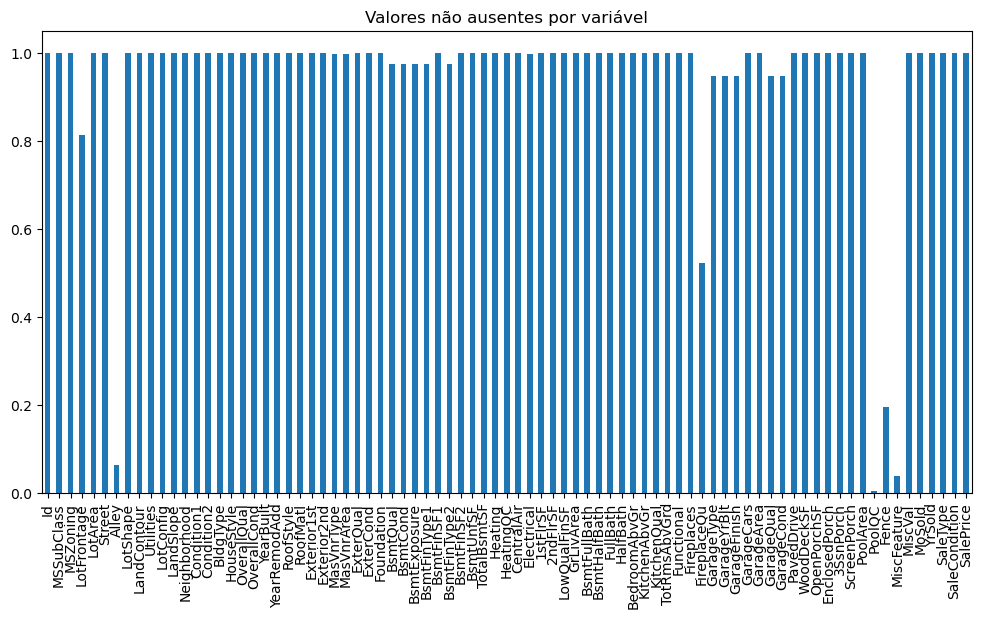

In [172]:
fig,ax = plt.subplots(figsize=(12,6))
plt.title('Valores não ausentes por variável')
(1- df_train.isnull().mean()).abs().plot.bar(ax=ax);

Podemos ver que existem diversos valores faltantes, sobretudo nas variáveis PoolQC (qualidade da piscina), MiscFeature (diversas categorias), Alley (tipo de acesso), Fence (qualidade da cerca), FireplaceQu (qualidade da lareira) e LotFrontage (extensão que fica de frente para a rua, em pés).

In [173]:
df_train['PoolQC'].unique()

array([nan, 'Ex', 'Gd', 'Fa'], dtype=object)

In [174]:
df_train['MiscFeature'].value_counts()

Shed    37
Othr     1
Gar2     1
TenC     1
Name: MiscFeature, dtype: int64

In [175]:
df_train['Alley'].value_counts()

Grvl    42
Pave    24
Name: Alley, dtype: int64

In [176]:
df_train['Fence'].value_counts()

MnPrv    111
GdPrv     41
GdWo      41
MnWw       8
Name: Fence, dtype: int64

In [177]:
df_train['FireplaceQu'].value_counts()

Gd    260
TA    219
Fa     23
Ex     18
Po     14
Name: FireplaceQu, dtype: int64

Podemos notar que a variável MiscFeature aparenta só possuir uma informação relevante, que seria "Shed" (cabana), para 49 imóveis.

**Sobre a ausência de valores:**

Valores faltantes em PoolQC indicam que a casa não possui piscina.  
Valores faltantes em Alley indicam que não existe "beco" que dê acesso à propriedade.  
Valores faltantes em Fence indicam que a casa não possui cerca.  
Valores faltantes em FireplaceQu indicam que a casa não possui lareira.

Valores faltantes em LotFrontage podem ser um problema. Vamos lidar com eles na sequência.

### 3.1 Conhecendo as variáveis

In [178]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### 3.2 Separando as variáveis por tipo

O objetivo final é separar variáveis quantitativas de variáveis qualitativas.  
Inicialmente, vamos separar com base no tipo (formato) da variável. Em seguida, vamos separar variáveis numéricas contínuas, discretas e categóricas.

In [179]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

A variável MSSubclass indica uma classe, apesar do formato ser numérico (inteiro).  
Vamos converter o formato para string, para tratar como classe de forma adequada.

In [180]:
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')
df_test['MSSubClass'] = df_test['MSSubClass'].astype('object')

In [181]:
# Separando as variáveis por formato

# Variável target
target=['SalePrice']

# Variáveis chave
key_vars=['Id']

# Variáveis string 
string_vars = df_train.select_dtypes(include='object').columns.to_list()

# Variáveis categóricas
cat_vars =[col for col in string_vars if col not in target + key_vars]

# Variáveis numéricas
num_vars =[col for col in df_train.columns if col not in target + key_vars + cat_vars]

# Features 
cat_vars + num_vars

print(f"target ={target}")
print("="*100)
print(f"key_vars ={key_vars}")
print("="*100)
print(f"cat_vars ={cat_vars}")
print("="*100)
print(f"num_vars ={num_vars}")
print("="*100)
print(f"Variáveis Totais: {len(df_train.columns)}")
print(f"Variáveis mapeadas: {len(target + key_vars + cat_vars + num_vars)}")

target =['SalePrice']
key_vars =['Id']
cat_vars =['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
num_vars =['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'Gara

### 3.3 Observando a correlação entre variáveis 

Como temos uma quantidade considerável de variáveis, convém checar se algumas dessas variáveis são redundantes, e podem ser removidas antes da modelagem.  
Essa etapa de feature selection pode ser feita verificando a correlação entre as variáveis, a fim de encontrar variáveis que tragam a mesma informação:

In [182]:
df_train[num_vars].corr().head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
LotFrontage,1.000000,0.431780,0.257083,-0.043450,0.119142,0.105432,0.218788,0.258606,0.080162,0.118083,...,0.346857,0.084104,0.145693,0.000461,0.075662,0.063899,0.295309,0.000797,0.022107,0.005971
LotArea,0.431780,1.000000,0.101323,0.007807,0.007050,0.018924,0.121115,0.225743,0.132485,-0.012321,...,0.169508,0.168974,0.085408,-0.022614,0.024860,0.051666,0.098962,0.058763,0.007455,-0.002990
OverallQual,0.257083,0.101323,1.000000,-0.072908,0.555794,0.546120,0.425872,0.217442,-0.058256,0.333477,...,0.554287,0.240900,0.273280,-0.120541,0.029495,0.050224,0.095900,-0.054523,0.055940,-0.028453
OverallCond,-0.043450,0.007807,-0.072908,1.000000,-0.375292,0.060953,-0.144462,-0.051918,0.066005,-0.150840,...,-0.126650,0.003838,-0.043362,0.060365,0.023793,0.067903,-0.013737,0.044669,0.006181,0.028067
YearBuilt,0.119142,0.007050,0.555794,-0.375292,1.000000,0.595816,0.325294,0.227290,-0.065733,0.183609,...,0.459207,0.218077,0.187432,-0.398825,0.032512,-0.056333,0.003575,-0.041857,0.012676,-0.000522


Não é possível tirar muitas conclusões com a tabela acima, dada a grande quantidade de variáveis.  
Assim, vamos montar um mapa de calor apenas com as variáveis que possuem um alto coeficiente de correlação (acima de 0.7) com alguma outra variável.

In [183]:
# Define o nível acima do qual as correlações serão analisadas
nivel_corr_analise = 0.7

# Retorna o df com as correlações entre todas as variáveis explicativas (numéricas)
df_correlation = df_train[num_vars].corr()

# Checando as maiores correlações encontradas:
print(f"Maior correlação positiva: {df_correlation[df_correlation!=1].max().max():,.3f}")
print(f"Maior correlação negativa: {df_correlation[df_correlation!=-1].min().min():,.3f}")

print("="*50)

# Separa uma lista com as variáveis com alta correlação, para serem analisadas
vars_alta_correl =[]

for var in num_vars:
    if var != df_correlation[df_correlation[var]> nivel_corr_analise].index[0]:   # se a variável tem alta correlação com outra variavel
        alta_corr = df_correlation[df_correlation[var]> nivel_corr_analise].index.to_list() # retorna uma lista com as variáveis
        print(alta_corr)
        vars_alta_correl.extend(alta_corr) # insere na lista

vars_alta_correl = list(set(vars_alta_correl))

Maior correlação positiva: 0.881
Maior correlação negativa: -0.488
['TotalBsmtSF', '1stFlrSF']
['GrLivArea', 'TotRmsAbvGrd']
['YearBuilt', 'GarageYrBlt']
['GarageCars', 'GarageArea']


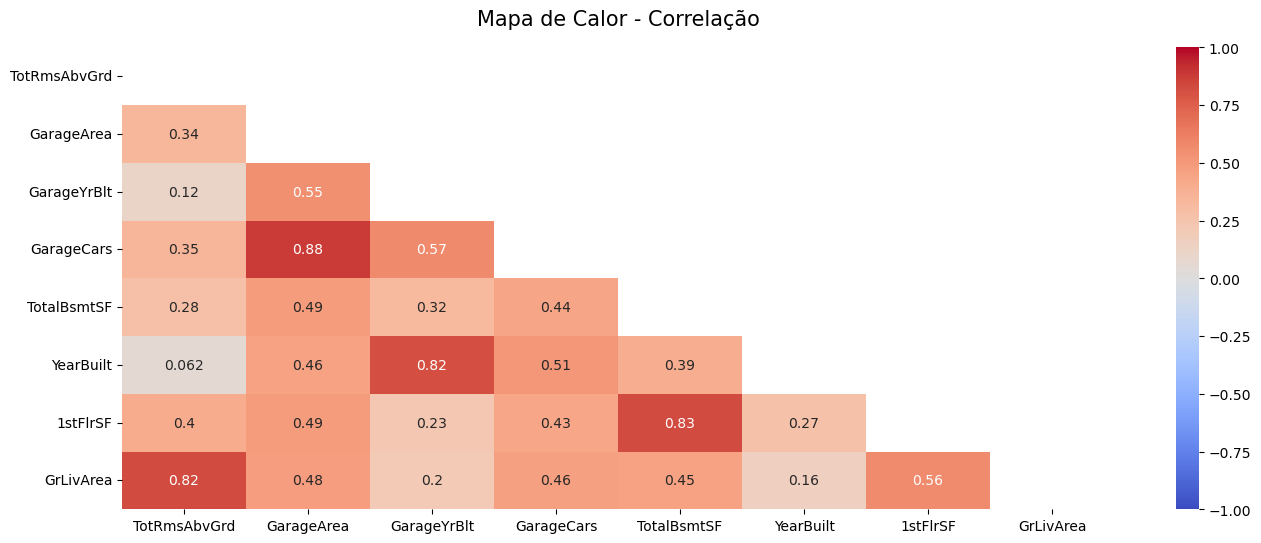

In [184]:
# Plotando o mapa de calor apenas com as variáveis que possuem alta correlação
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_train[vars_alta_correl].corr()))

heatmap = sns.heatmap(df_train[vars_alta_correl].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Mapa de Calor - Correlação', fontdict={'fontsize':15}, pad=16);

Temos que:  
**GarageArea** (tamanho da garagem) e **GarageCars** (capacidade da garagem) possuem alta correlação (0.88). Isso indica que a informação é redundante, podendo eliminar uma das duas variáveis.  

**TotRmsAbvGrd** (quantidade de quartos acima do primeiro piso) e **GrLivArea** (área de convivência acima do primeiro piso) são correlacionadas, o que também aparenta indicar redundância.

**GarageYrBlt** (ano e construção da garagem) e **YearBuilt** (ano de construção da casa) possuem alta correlação, visto que geralmente a garagem é construída no mesmo ano que a casa.  

**TotalBsmtSF** (área total do porão) e **1stFlrSF** (área do primeiro piso) possuem alta correlação, o que deve ao fato que geralmente o porão tem dimensões semelhantes ao do primeiro piso.

E agora? Quais variáveis remover?

Poderíamos recorrer ao conhecimento do negócio e dizer, por exemplo, que a capacidade da garagem é mais importante que sua área.  
Mas vamos trabalhar com base nos dados, analisando qual das variáveis possui maior correlação com o preço da casa, que é nosso target.

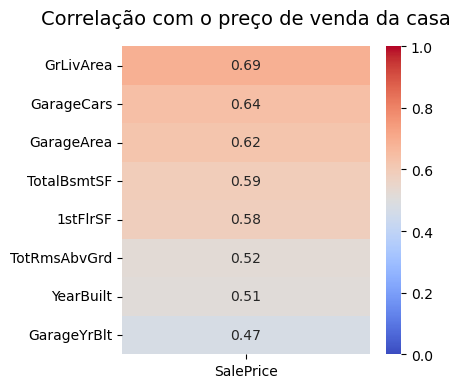

In [185]:
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(df_train[vars_alta_correl + target].corr()[['SalePrice']]
                      .sort_values(by='SalePrice', ascending=False)
                      .drop('SalePrice'), 
                      vmin=0, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlação com o preço de venda da casa', fontdict={'fontsize':14}, pad=16);

Assim, podemos decidir quais variáveis manter e quais variáveis descartar.

**GarageArea** x **GarageCars** = manter **GarageCars**  

**TotRmsAbvGrd** vs **GrLivArea** = manter **GrLivArea** 

**GarageYrBlt** vs **YearBuilt** = manter **YearBuilt**  

**TotalBsmtSF** vs **1stFlrSF** = manter ambos, pois possuem a mesma correlação com o preço de venda da casa.

Vamos armazenar as variáveis redundantes em uma lista para usar posteriormente:

In [186]:
var_redundantes = ['GarageArea', 'TotRmsAbvGrd', 'GarageYrBlt']

### 3.4 Analisando a dispersão das variáveis

Inicialmente, vamos obter as principais medidas-resumo das variáveis numéricas:

Vamos também tentar identificar valores discrepantes (outliers), usando uma escala de 1.7.  
Esse valor corresponde a aproximadamente 3 desvios-padrão (99.7% dos dados)em uma distribuição Gaussiana (normal).

In [187]:
outliers_scale = 1.7

resumo_cont = df_train[num_vars].describe()

p75 = resumo_cont.loc["75%",:].to_list()

p25 = resumo_cont.loc["25%",:].to_list()

IQR =[]

for p_75, p_25 in zip(p75, p25):
    iqr = p_75 - p_25
    IQR.append(iqr)
    
IQR_df = pd.DataFrame(IQR, columns=['IQR'], index=num_vars).T
resumo_cont1 = pd.concat([resumo_cont, IQR_df])
resumo_cont1

lim_sup = []
lim_inf = []

for p_75, p_25, iqr in zip(p75, p25, IQR):
    sup = p_75 + outliers_scale * iqr
    lim_sup.append(sup)
    inf = p_25 - outliers_scale *iqr
    lim_inf.append(inf)
    
sup_df = pd.DataFrame(lim_sup, columns=['lim_sup'], index=num_vars).T
inf_df = pd.DataFrame(lim_inf, columns=['lim_inf'], index=num_vars).T

describe_df = pd.concat([resumo_cont1, sup_df, inf_df])
describe_df

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,831.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1018.000000,1021.000000,1021.000000,1021.000000,...,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000
mean,70.363418,10745.775710,6.127326,5.564153,1970.996082,1984.771792,105.081532,446.613124,42.410382,570.505387,...,477.068560,97.548482,49.573947,21.324192,3.885406,15.580803,2.746327,41.606268,6.365328,2007.813908
std,25.546797,11335.300697,1.371791,1.111018,30.763870,20.752128,172.697461,459.984288,151.278814,445.632262,...,208.538869,131.756411,69.222501,61.560919,32.563446,56.471306,39.690880,338.295563,2.651069,1.326444
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7560.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,223.000000,...,350.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,390.000000,0.000000,483.000000,...,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11700.000000,7.000000,6.000000,2001.000000,2004.000000,170.000000,724.000000,0.000000,808.000000,...,576.000000,171.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000
IQR,21.000000,4140.000000,2.000000,1.000000,48.000000,38.000000,170.000000,724.000000,0.000000,585.000000,...,226.000000,171.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
lim_sup,115.700000,18738.000000,10.400000,7.700000,2082.600000,2068.600000,459.000000,1954.800000,0.000000,1802.500000,...,960.200000,461.700000,197.100000,0.000000,0.000000,0.000000,0.000000,0.000000,13.100000,2012.400000


Variável 'LotFrontage' possui 29 outliers
Variável 'LotArea' possui 42 outliers
Variável 'OverallCond' possui 62 outliers
Variável 'MasVnrArea' possui 50 outliers
Variável 'BsmtFinSF1' possui 3 outliers
Variável 'BsmtFinSF2' possui 111 outliers
Variável 'BsmtUnfSF' possui 8 outliers
Variável 'TotalBsmtSF' possui 13 outliers
Variável '1stFlrSF' possui 8 outliers
Variável '2ndFlrSF' possui 1 outliers
Variável 'LowQualFinSF' possui 19 outliers
Variável 'GrLivArea' possui 15 outliers
Variável 'BsmtFullBath' possui 1 outliers
Variável 'BsmtHalfBath' possui 60 outliers
Variável 'BedroomAbvGr' possui 19 outliers
Variável 'KitchenAbvGr' possui 47 outliers
Variável 'TotRmsAbvGrd' possui 21 outliers
Variável 'Fireplaces' possui 3 outliers
Variável 'GarageCars' possui 1 outliers
Variável 'GarageArea' possui 11 outliers
Variável 'WoodDeckSF' possui 21 outliers
Variável 'OpenPorchSF' possui 46 outliers
Variável 'EnclosedPorch' possui 138 outliers
Variável '3SsnPorch' possui 17 outliers
Variável 'Sc

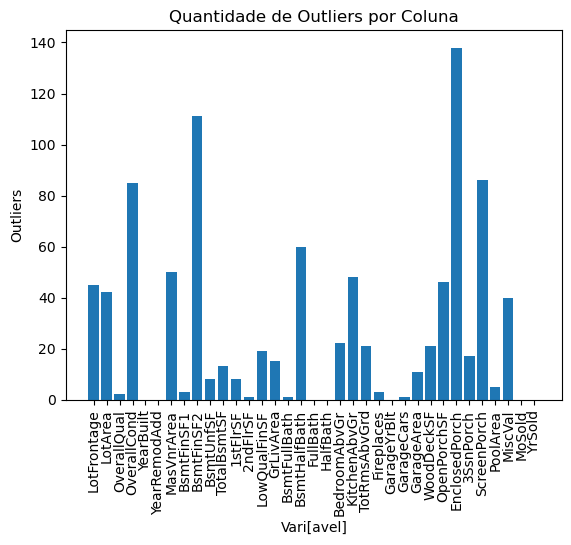

In [188]:
df = df_train[num_vars]
outliers_qtd = []
# itera sobre cada coluna do conjunto de dados
for coluna in df.columns:
    # calcula o IOR
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile (0.75)
    IQR = q3 - q1
    # define os limites de corte
    lim_sup = q3 + outliers_scale * IQR
    lim_inf = q1 - outliers_scale * IQR
    # conta o número de outliers acima e abaixo dos limites de cor
    n_outliers_sup = len(df[df[coluna] > lim_sup])
    n_outliers_inf = len(df[df[coluna] < lim_inf])

    # armazena a quantidade de outliers em cada coluna
    outliers_qtd.append(n_outliers_sup + n_outliers_inf)
    # exibe o número de outliers encontrados para cada variável 
    if n_outliers_sup > 0 :
        print (f"Variável '{coluna}' possui {n_outliers_sup} outliers")
    
    # plotar o histograma dos outliers
plt.bar (df.columns, outliers_qtd)
plt.xlabel('Vari[avel]')
plt.ylabel('Outliers')
plt.title("Quantidade de Outliers por Coluna")
plt.xticks(rotation=90)
plt.show()

Algumas variáveis apresentam uma quantidade considerável de valores discrepantes, como é o caso de EnclosedPorchSF (área de varanda fechada), dificultando a decisão de manter ou remover essas observações.  

Seguimos então para outras visualizações de distribuição.

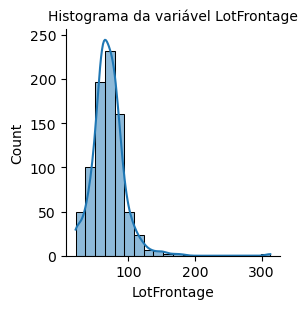

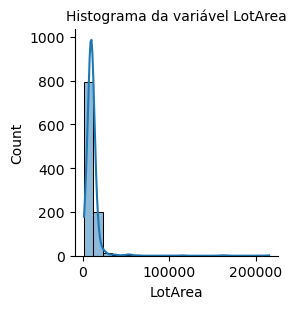

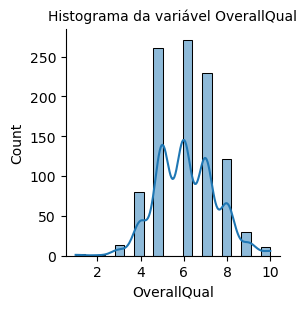

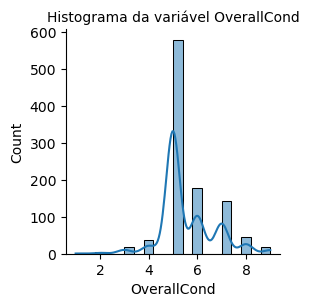

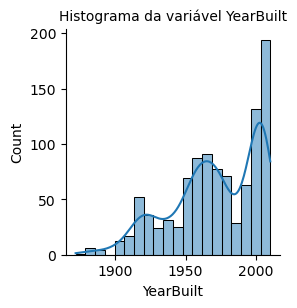

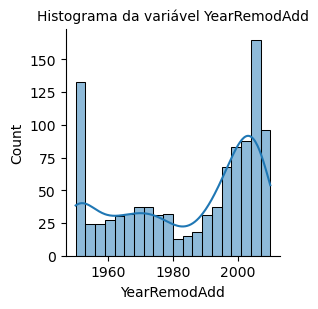

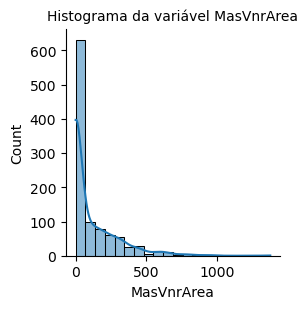

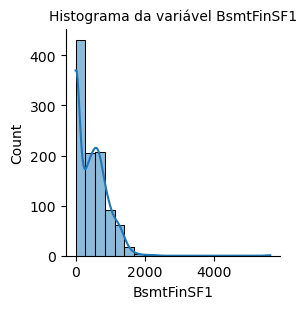

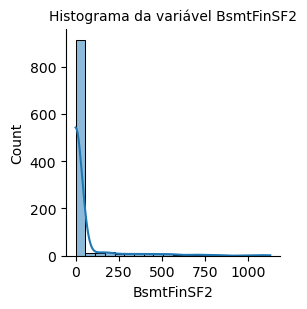

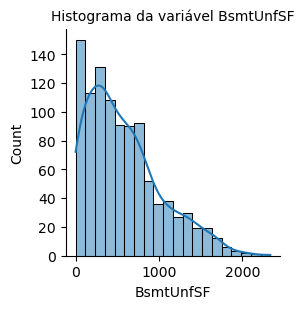

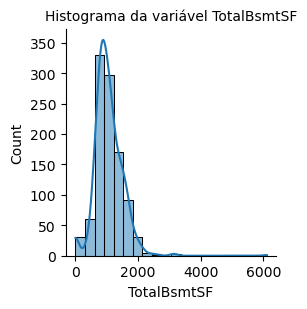

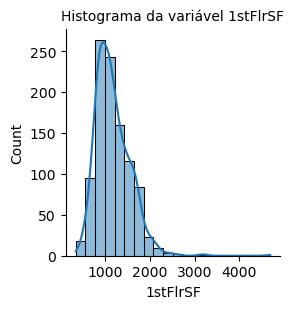

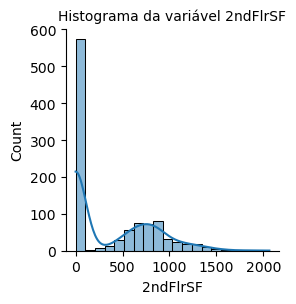

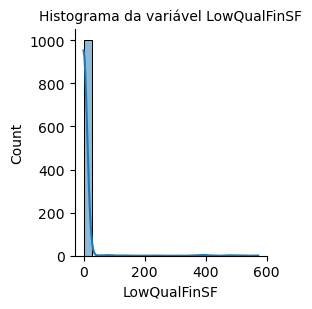

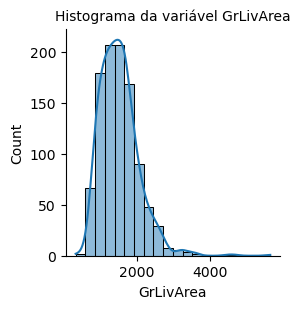

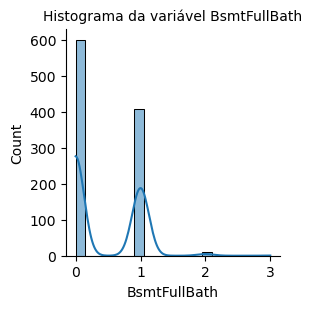

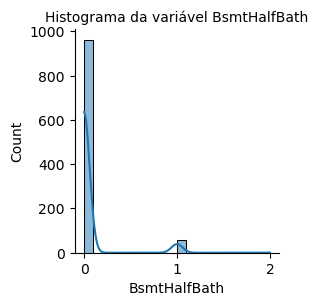

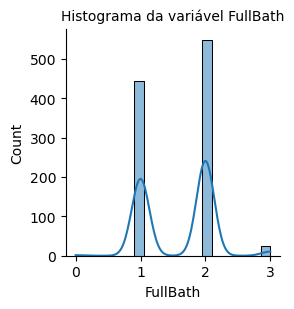

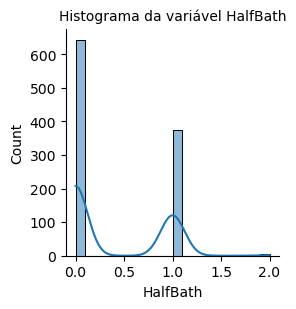

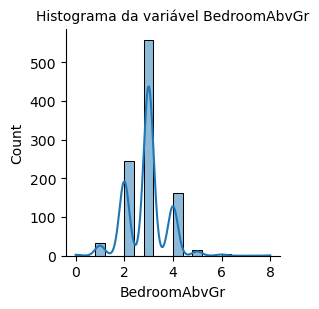

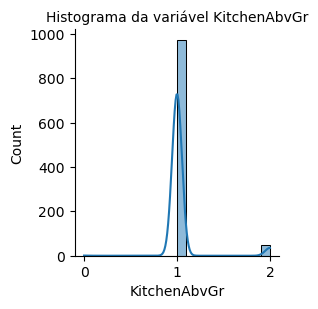

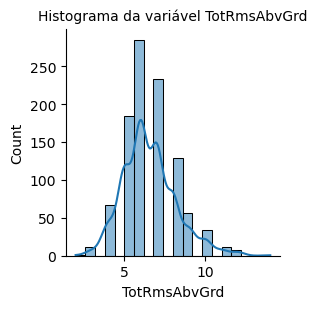

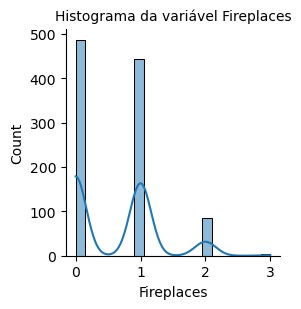

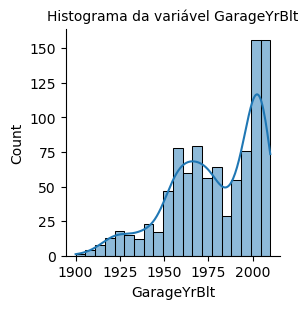

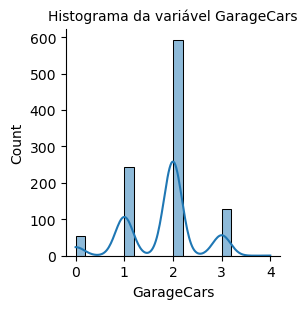

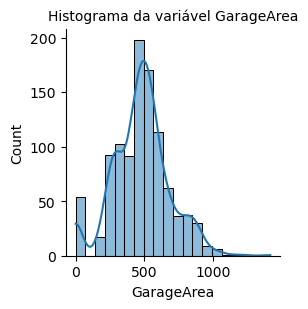

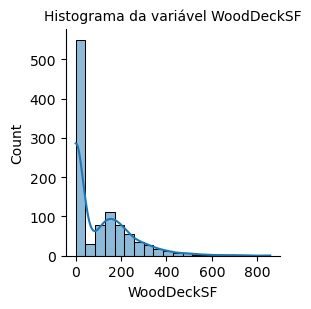

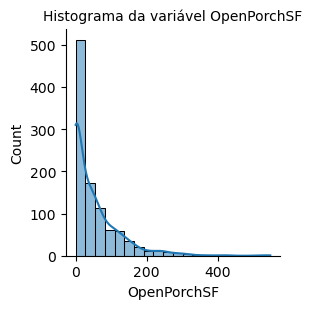

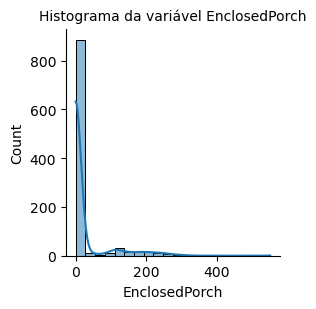

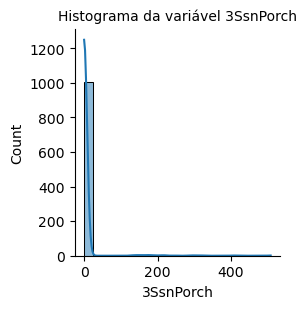

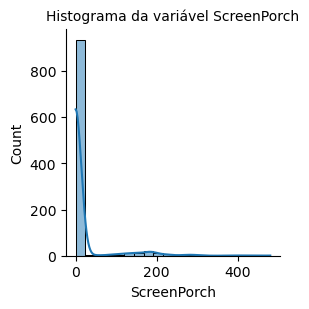

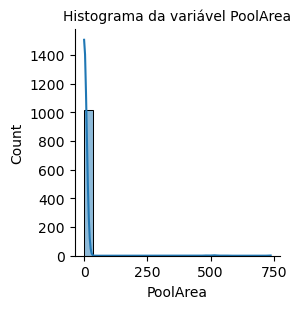

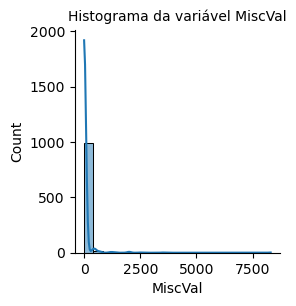

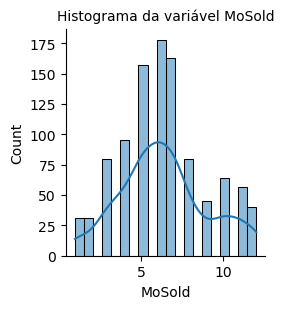

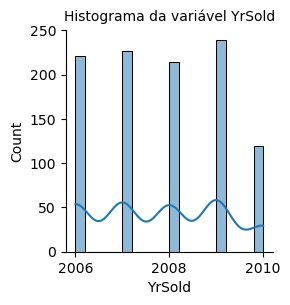

In [189]:
df = df_train[num_vars]
for coluna in df.columns:
    sns.displot(df[coluna], kde=True, bins=20, height=3)
    plt.title(f"Histograma da variável {coluna}", fontdict={'fontsize':10})
    plt.show()

Algumas variáveis possuem distribuição aproximadamente normal. Nessas, vamos remover os outliers.  

Outras variáveis parecem ser inúteis. Nessas, vamos checar a correlação com a variável target antes de remover.  

Muitas variáveis parecem ter vários valores zerados. Mas fazem sentido, seriam como "NaN".  
Ideia: testar um valor negativo, totalmente fora da distribuição, como -1mil

**Variáveis com distribuição aproximadamente normal.**  
Nessas variáveis, vamos realizar a remoção de outliers, visto que são observações que estão discrepantes em relação à distribuição.

In [190]:
num_var_dist_normal = [
    'LotFrontage', 
    'LotArea', 
    'TotalBsmtSF', 
    '1stFlrSF', 
    '2ndFlrSF', 
    'GrLivArea', 
    'WoodDeckSF' ,
]

### 3.5 Exploração das variáveis qualitativas

Assim, finalizamos a exploração de variáveis quantitativas, partindo para a análise das variáveis qualitativas.

In [191]:
for var in df_train[cat_vars]:
    print(f"Variável:{var} | Valores possíveis: {df_train[var].unique()}")

Variável:MSSubClass | Valores possíveis: [180 60 20 80 50 75 30 70 90 120 45 190 85 160 40]
Variável:MSZoning | Valores possíveis: ['RM' 'FV' 'RL' 'C (all)' 'RH']
Variável:Street | Valores possíveis: ['Pave' 'Grvl']
Variável:Alley | Valores possíveis: [nan 'Pave' 'Grvl']
Variável:LotShape | Valores possíveis: ['Reg' 'IR1' 'IR2' 'IR3']
Variável:LandContour | Valores possíveis: ['Lvl' 'HLS' 'Bnk' 'Low']
Variável:Utilities | Valores possíveis: ['AllPub' 'NoSeWa']
Variável:LotConfig | Valores possíveis: ['Inside' 'Corner' 'CulDSac' 'FR2' 'FR3']
Variável:LandSlope | Valores possíveis: ['Gtl' 'Mod' 'Sev']
Variável:Neighborhood | Valores possíveis: ['Edwards' 'Somerst' 'CollgCr' 'NAmes' 'SawyerW' 'Sawyer' 'Gilbert'
 'OldTown' 'BrkSide' 'SWISU' 'ClearCr' 'StoneBr' 'Crawfor' 'Mitchel'
 'NoRidge' 'NWAmes' 'Blmngtn' 'Veenker' 'Timber' 'IDOTRR' 'NridgHt'
 'BrDale' 'MeadowV' 'NPkVill' 'Blueste']
Variável:Condition1 | Valores possíveis: ['Norm' 'RRNn' 'PosN' 'Feedr' 'PosA' 'Artery' 'RRAn' 'RRAe' 'RR

Parte das variáveis qualitativas apresentam um status de qualidade (ruim, normal, bom). Essas classes possuem uma ordem lógica de grandeza. "Normal" é maior que "Ruim", mas é menor do que "Bom".  

Assim, temos duas alternativas:  
1) Transformar as categorias em variáveis dummy, e usar o "normal" como baseline;
2) Transformar as categorias em números inteiros, preservando a ordem de qualidade

Vamos realizar as duas transformações, e testar qual delas resulta em um modelo melhor.

In [192]:
# Variáveis qualitativas que envolvem relaçoes de grandeza (ordem)
var_qual_ord =[
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'
]

As demais variáveis serão consideradas como variáveis qualitativas "tradicionais".

In [193]:
var_qual_class = [var for var in  df_train[cat_vars] if var not in var_qual_ord]

In [194]:
print(f"Total de variáveis categóricas: {df_train[cat_vars].shape[1]}")
print(f"Variáveis categóricas mapeadas: {len(var_qual_ord) + len(var_qual_class)}")
print(f"Variáveis categóricas de ordem: {len(var_qual_ord)}")
print(f"Variáveis categóricas de classe: {len(var_qual_class)}")

Total de variáveis categóricas: 44
Variáveis categóricas mapeadas: 44
Variáveis categóricas de ordem: 14
Variáveis categóricas de classe: 30


## 4. Preparação dos Dados

### 4.1 Remoção de variáveis redundantes

Removendo as variáveis que já detectamos que não agregam informação, armazenadas na lista [var_redundantes].

In [195]:
df_train_without_high_corr = df_train.drop(var_redundantes, axis=1)
num_vars = [i for i in num_vars if i not in var_redundantes]

print(f"Qtde inicial de variáveis: {df_train.shape[1]}")
print(f"Qtde de variáveis removidas: {len(var_redundantes)}")
print(f"Qtde final de variáveis: {df_train_without_high_corr.shape[1]}")

Qtde inicial de variáveis: 81
Qtde de variáveis removidas: 3
Qtde final de variáveis: 78


### 4.2 Tratamento de valores faltantes

**Variáveis categóricas:**  
Vamos substituir os valores faltantes pela string 'NA'.  
Dessa forma, criamos uma classe que indica a ausência do atributo. Ex: PoolQC='NA' significa que a casa não possui piscina.  
A qualidade da piscina pode ser importante para as casas que possuem piscina.  
Para as casas que não possuem, sempre terão qualidade='NA'

In [196]:
df = df_train_without_high_corr

for col in df[cat_vars]:
    df[col] = df[col].fillna('NA')

df_fill_cat_vars = df

print(f"Qtde inicial de variáveis: {df_train_without_high_corr.shape[1]}")
print(f"Qtde final de variáveis: {df_fill_cat_vars.shape[1]}")

Qtde inicial de variáveis: 78
Qtde final de variáveis: 78


**Variáveis numéricas:**  
Para variáveis numéricas, temos dois tipos de abordagem:
- Valores realmente faltantes (missing), vamos preencher com a mediana dos dados.
- Valores faltantes sob a forma de 0 (zero), que indicam ausência do atributo: vamos substituir por um valor completamente fora da distribuição (ex: -1.000)

Como não existem distâncias ou áreas iguais a zero, para variáveis que indicam área ou distância, vamos substituir os valores iguais a zero por -1.000 (um valor completamente fora da distribuição).

In [197]:
var_num_dist_area = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea'   
]

In [198]:
df = df_fill_cat_vars

for col in df[var_num_dist_area]:
    df[col] = df[col].fillna(0)
    df[col] = df[col].apply(lambda x : x if x != 0 else -1000)
    df[col]
    
df_ajust_area_vars = df

In [199]:
print(f"Qtde inicial de variáveis: {df_fill_cat_vars.shape[1]}")
print(f"Qtde final de variáveis: {df_ajust_area_vars.shape[1]}")

Qtde inicial de variáveis: 78
Qtde final de variáveis: 78


Para as demais variáveis numéricas, vamos seguir com o imputamento de valores faltantes pela mediana.

In [200]:
num_var_exc_area = [var for var in num_vars if var not in var_num_dist_area] 

In [201]:
df = df_ajust_area_vars
for col in df[num_var_exc_area]:
    df[col].fillna(df[col].median())
    
df_without_null = df

In [202]:
print(f"Qtde inicial de variáveis: {df_ajust_area_vars.shape[1]}")
print(f"Qtde final de variáveis: {df_without_null.shape[1]}")

Qtde inicial de variáveis: 78
Qtde final de variáveis: 78


### 4.2 Tratamento de valores outliers

Para as variáveis com distribuição aproximadamente normal, vamos substituir os valores discrepantes (outliers, que estão acima do limite superior) pelo limite superior.  
No caso da variável LotFrontage, fazer isso resulta em muitos valores iguais ao limite superior, vamos dar uma tolerância maior (3 vezes o valor do limite superior). 

In [203]:
df = df_without_null

for col in num_var_dist_normal:
    if col=='LotFrontage':
        df[col] = df[col].apply(lambda x : x if x < (describe_df[col].iloc[-2]*3) else describe_df[col].iloc[-2])
    else:
        df[col] = df[col].apply(lambda x : x if x < describe_df[col].iloc[-2] else describe_df[col].iloc[-2])

In [204]:
df_without_outliers = df

Plotando novamente os histogramas novamente, para verificar a distribuição:

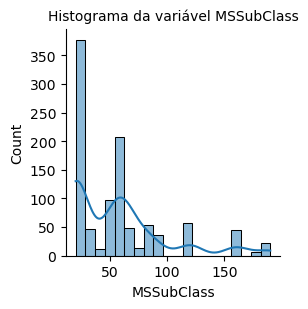

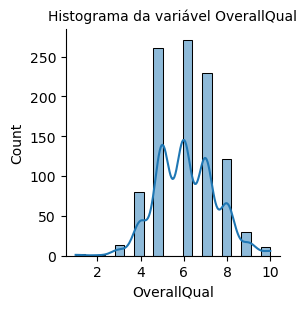

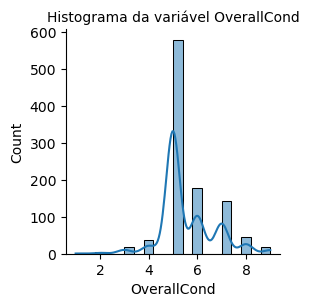

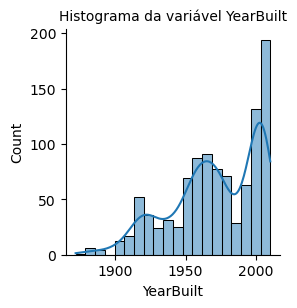

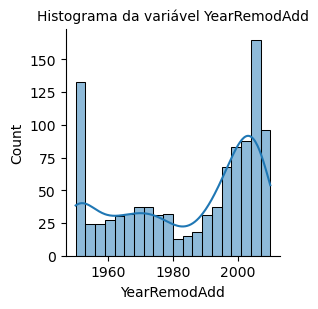

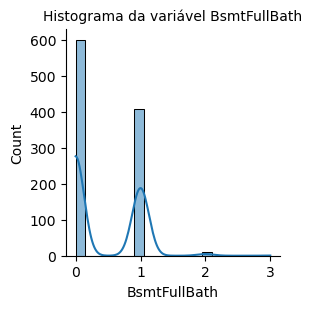

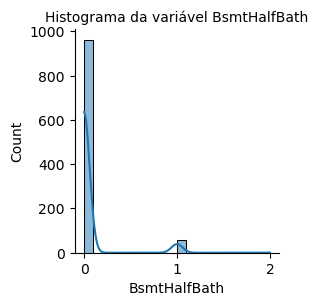

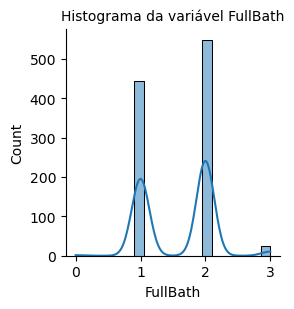

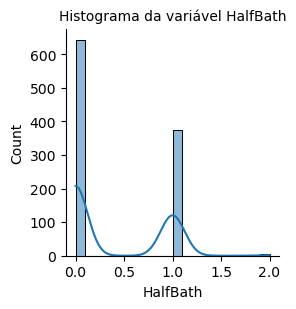

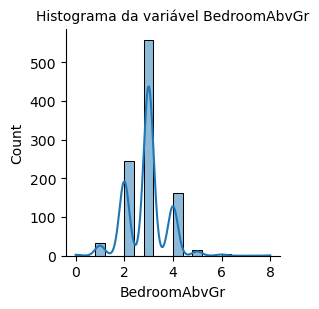

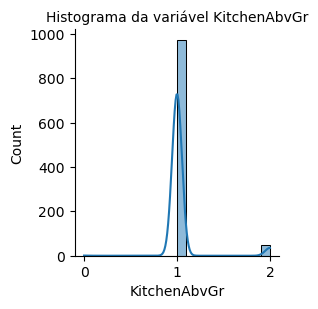

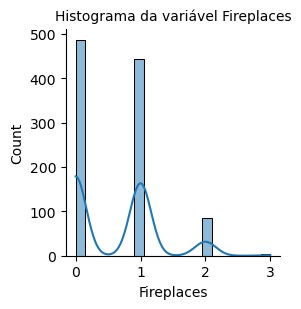

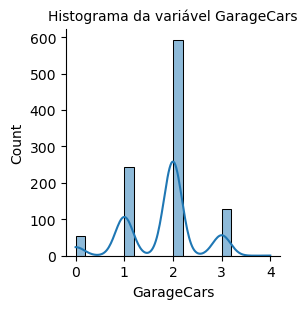

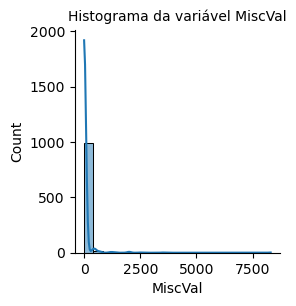

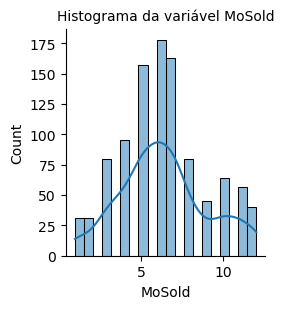

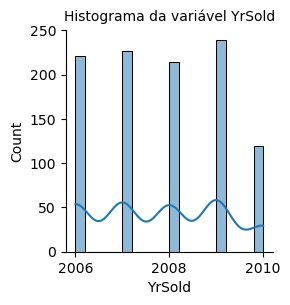

In [208]:
df = df_without_outliers[num_vars]
for coluna in df.columns:
    sns.displot(df[coluna], kde=True, bins=20, height=3)
    plt.title(f"Histograma da variável {coluna}", fontdict={'fontsize':10})
    plt.show()

### 4.3 Transformando as variáveis categóricas

Primeira abordagem: Transformar todas as variáveis categóricas em variáveis dummy, e remover o baseline das variáveis que indicam ordem.  
Vamos fazer isso através do one hot encoder.

Segunda abordagem: Transformar as variáveis de classe em dummies, e transformar as variáveis que indicam ordem em números inteiros sequenciais.

## 5. Modelagem - Treinamento e seleção de modelos

Vamos fazer a modelagem a partir do dataframe que recebeu todos os tratamentos.

In [209]:
df_train = df_without_outliers

# Variável target
target=['SalePrice']

# Variáveis chave
key_vars=['Id']

# Variáveis string 
string_vars = df_train.select_dtypes(include='object').columns.to_list()

# Variáveis categóricas
cat_vars =[col for col in string_vars if col not in target + key_vars]

# Variáveis de área
area_vars = [col for col in df_train.columns if col in var_num_dist_area]

# Variáveis numéricas
num_vars =[col for col in df_train.columns if col not in target + key_vars + cat_vars + area_vars]

# Features 
features = cat_vars + num_vars + area_vars

print(df_train.shape)
print(len(features))


(1021, 78)
76


Para modelagem, vamos criar um pipeline de dados, onde vamos realizar o encoder das variáveis categóricas, a padronização das variáveis numéricas, para posteriormente aplicar os algoritmos de regressão:

In [210]:
X_train = df_train[features]
y_train = df_train[target]

linear_model_pipe = Pipeline(steps=[
    ("num_area_imputer", ArbitraryNumberImputer(arbitrary_number=-999, variables=area_vars)),
    ("num_var_imputer", MeanMedianImputer(imputation_method='median', variables=num_vars)),
    ("cat_imputer", CategoricalImputer(fill_value='NA', variables=cat_vars, return_object=True)),
    ("numeric_scaler", SklearnTransformerWrapper(variables=num_vars, transformer = StandardScaler())),  # Padronizando as variáveis numéricas para terem média 0 e variância 1
    ("one_hot_encoder", OneHotEncoder(variables=cat_vars, ignore_format=True)),                                          # Utilizando o OneHotEncoder para transformar as variáveis categóricas em variáveis binárias                                             # Definindo o algoritmo a ser aplicado
])


X_train = linear_model_pipe.fit_transform(X_train)

/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/feature_engine/encoding/one_hot.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/feature_engine/encoding/one_hot.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/feature_engine/encoding/one_hot.py:26

Como trata-se de uma regressão linear, não precisamos de todas as variáveis binárias criadas.  
Ex: A variável Street pode apresentar dois valores: Grvl e Pave. Logo, basta utilizar uma dummy para Grvl.  
Se o valor for igual a 1 significa que é Gravel. Se for igual a 0, siginifica que é Paved

Outra forma de remover variáveis desnecessárias é manter o que for "normal" ou "average" como baseline.  
Ex: Imagine uma variável X que possui os valores Ruim, Normal e Bom.  
Em uma regressão, espera-se que o coeficiente atrelado a X_Normal seja maior do que o coeficiente do X_Ruim, e menor do que o coeficiente de X_Bom.  
Logo, podemos descartar o X_Normal (será o baseline) e observar se o coeficiente de X_Ruim é negativo e o de X_Bom é positivo.

In [211]:
X_train = X_train.drop([
    'Condition1_Norm',
    'Condition2_Norm',
    'SaleCondition_Normal',
    'ExterQual_TA',
    'ExterCond_TA',
    'BsmtQual_TA',
    'BsmtCond_TA',
    'BsmtExposure_Av',
    'HeatingQC_TA',
    'CentralAir_N',
    'KitchenQual_TA',
    'FireplaceQu_TA',
    'GarageQual_TA',
    'GarageCond_TA',
    'PavedDrive_N',
],axis=1)

Como trata-se de um modelo de regressão linear, vamos inserir um intercepto.  
Em uma regressão linear simples, o intercepto é o valor que a variável dependente assume quando a variável explicativa é igual a zero.

In [214]:
X_train['intercept'] = np.ones(X_train.shape[0])

/var/folders/2c/7wl_zw31207_kg3t9tss68nw0000gn/T/ipykernel_32744/3166807375.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['intercept'] = np.ones(X_train.shape[0]);


Após todos esses tratamentos, vemos que a base de treinamento ainda possui muitas variáveis (essa é uma desvantagem do OneHotEncoder):

In [215]:
X_train.shape[1]

282

Vamos treinar um modelo de regressão linear, usando o método de mínimos quadrados ordinários (MQO) e avaliar o poder preditivo de um modelo com todas essas variáveis.

In [227]:
from sklearn.linear_model import LinearRegression

modelo_base = LinearRegression()

modelo_base.fit(X_train, y_train)

modelo_base.score(X_train, y_train)

0.9388158221591204

Vemos que o modelo possui um alto R<sup>2</sup>, de 0,939.    
Porém, isso pode ser consequência da alta quantidade de variáveis explicativas, visto que o R<sup>2</sup> sempre aumenta com o acréscimo de variáveis, e possuímos 281 variáveis (além do intercepto criado).

Vamos realizar um processo de feature_selection, onde iremos analisar o p-valor associado ao coeficiente de cada variável, e ir retirando as variáveis que possuam um p-valor alto.

Para isso, vamos usar o statsmodel:

In [285]:
model = sm.OLS(endog=y_train, exog=X_train)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     49.06
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:02:25   Log-Likelihood:                -11518.
No. Observations:                1021   AIC:                         2.352e+04
Df Residuals:                     777   BIC:                         2.473e+04
Df Model:                         243                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass             4930.7059   5457.284      0.904      0.367   -5782.062    1.56e+04
OverallQual            9964.3629   1720.208      5.793      0.000    6587.556    1.33e+04
OverallCond            5657.8164   1175.784      4.812      0.000    3349.726    7965.906
YearBuilt              9229.9732   2789.128      3.309      0.001    3754.853    1.47e+04
YearRemodAdd           2639.3028   1416.151      1.864      0.063    -140.633    5419.239
BsmtFullBath           2181.1017   1248.586      1.747      0.081    -269.900    4632.103
BsmtHalfBath            137.4196    883.779      0.155      0.876   -1597.458    1872.297
FullBath               2443.6865   1436.496      1.701      0.089    -376.186    5263.559
HalfBath               -541.6972   1269.089     -0.427      0.670   -3032.947    1949.553
BedroomAbvGr          -3263.7163   1263.227     -2.584      0.010   -5743.458    -783.975
KitchenAbvGr          -2557.8968   1620.866     -1.578      0.115   -5739.693     623.899
Fireplaces             2631.2904   2013.689      1.307      0.192   -1321.625    6584.206
GarageCars             6301.5937   1418.718      4.442      0.000    3516.619    9086.568
MiscVal                2146.5982   2690.686      0.798      0.425   -3135.278    7428.474
MoSold                -1467.6693    792.778     -1.851      0.065   -3023.910      88.572
YrSold                 -496.6546    830.669     -0.598      0.550   -2127.275    1133.966
LotFrontage               0.5858      2.132      0.275      0.784      -3.600       4.771
LotArea                   1.5569      0.382      4.073      0.000       0.807       2.307
MasVnrArea               11.9064      5.544      2.148      0.032       1.023      22.790
BsmtFinSF1               15.3216      6.036      2.538      0.011       3.473      27.170
BsmtFinSF2               10.4086     11.877      0.876      0.381     -12.907      33.724
BsmtUnfSF                 0.8439      4.178      0.202      0.840      -7.357       9.045
TotalBsmtSF              20.6589      7.696      2.684      0.007       5.551      35.766
1stFlrSF                -14.1535     13.180     -1.074      0.283     -40.026      11.719
2ndFlrSF                  1.1237      7.309      0.154      0.878     -13.223      15.471
LowQualFinSF            -10.3161      7.330     -1.407      0.160     -24.705       4.073
GrLivArea                63.2342     11.818      5.351      0.000      40.036      86.433
WoodDeckSF                1.6465      1.508      1.092      0.275      -1.314       4.607
OpenPorchSF               1.1785      1.798      0.655      0.512      -2.351       4.708
EnclosedPorch             1.9913      2.429      0.820      0.413      -2.777       6.760
3SsnPorch                10.0346      5.148      1.949      0.052      -0.072      20.141
ScreenPorch            

Podemos notar que o R<sup>2</sup> encontrado é exatamente o mesmo que foi obtido usando a sklearn (0,939).

Agora, vamos realizar algumas iterações onde separamos as variáveis que possuem um alto p-valor, para removê-las e analisar se isso impactou no poder preditivo do modelo.

In [286]:
resumo_modelo = pd.DataFrame(summarize(results))
resumo_modelo.sort_values(by = 'P>|t|', ascending=False)

,coef,std err,t,P>|t|
Exterior2nd_BrkFace,-4.8044,9169.637,-0.001,1.000
ExterCond_Gd,-24.2997,2925.671,-0.008,0.993
GarageCond_Gd,175.3860,10300.000,0.017,0.986
Neighborhood_Blueste,-753.5107,22800.000,-0.033,0.974
Exterior1st_CemntBd,486.1275,14800.000,0.033,0.974
...,...,...,...,...
LotShape_Reg,-47670.0000,6431.286,-7.413,0.000
Alley_Grvl,-62610.0000,8689.285,-7.205,0.000
Foundation_PConc,-21940.0000,5498.823,-3.989,0.000
Foundation_CBlock,-23460.0000,5568.277,-4.214,0.000


Resgatando as variaveis com P valor maior que 0.05

In [287]:
order_p_value = resumo_modelo[resumo_modelo['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 125 variáveis com p-valor acima de 0.05


Criando um novo conjunto de dados sem as variáveis com alto p-valor e submetendo novamente a um algortimo de mínimos quadrados ordinários:

In [288]:
X_train2= X_train.drop(var_high_p_value, axis=1)

model2 = sm.OLS(endog=y_train, exog=X_train2)

model2.fit()
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     85.52
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:02:28   Log-Likelihood:                -11592.
No. Observations:                1021   AIC:                         2.346e+04
Df Residuals:                     884   BIC:                         2.413e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
OverallQual            1.154e+04   1498.933      7.702      0.000    8602.922    1.45e+04
OverallCond            6454.7305    922.593      6.996      0.000    4644.003    8265.458
YearBuilt              1.102e+04   2176.332      5.064      0.000    6748.725    1.53e+04
BedroomAbvGr          -3604.1212   1120.429     -3.217      0.001   -5803.132   -1405.110
GarageCars             6865.8933   1300.974      5.278      0.000    4312.535    9419.252
LotArea                   1.7747      0.343      5.176      0.000       1.102       2.448
MasVnrArea               10.6191      5.298      2.004      0.045       0.221      21.017
BsmtFinSF1               17.2527      3.135      5.503      0.000      11.099      23.406
TotalBsmtSF              17.6230      4.586      3.842      0.000       8.621      26.625
GrLivArea                59.3565      4.046     14.671      0.000      51.416      67.297
ScreenPorch               6.9914      2.317      3.017      0.003       2.444      11.539
PoolArea               7648.8331    788.771      9.697      0.000    6100.750    9196.916
MSZoning_RM           -3.856e+04   6378.710     -6.045      0.000   -5.11e+04    -2.6e+04
MSZoning_FV            -3.16e+04   7235.906     -4.367      0.000   -4.58e+04   -1.74e+04
MSZoning_RL           -3.639e+04   6242.988     -5.828      0.000   -4.86e+04   -2.41e+04
MSZoning_C (all)      -6.789e+04   1.19e+04     -5.714      0.000   -9.12e+04   -4.46e+04
MSZoning_RH            -3.67e+04   8155.013     -4.501      0.000   -5.27e+04   -2.07e+04
Street_Pave           -1.032e+05   1.44e+04     -7.178      0.000   -1.31e+05    -7.5e+04
Street_Grvl            -1.08e+05   1.47e+04     -7.344      0.000   -1.37e+05   -7.91e+04
Alley_NA              -7.474e+04   8908.458     -8.390      0.000   -9.22e+04   -5.73e+04
Alley_Pave            -6.434e+04   9477.376     -6.789      0.000   -8.29e+04   -4.57e+04
Alley_Grvl            -7.205e+04   9309.355     -7.740      0.000   -9.03e+04   -5.38e+04
LotShape_Reg          -5.323e+04   6913.078     -7.700      0.000   -6.68e+04   -3.97e+04
LotShape_IR1          -5.576e+04   6941.031     -8.033      0.000   -6.94e+04   -4.21e+04
LotShape_IR2          -5.555e+04   7685.623     -7.228      0.000   -7.06e+04   -4.05e+04
LotShape_IR3          -4.659e+04   9738.692     -4.784      0.000   -6.57e+04   -2.75e+04
LandContour_Lvl       -5.336e+04   7029.203     -7.592      0.000   -6.72e+04   -3.96e+04
LandContour_HLS       -3.882e+04   7620.225     -5.095      0.000   -5.38e+04   -2.39e+04
LandContour_Bnk       -5.708e+04   7409.483     -7.704      0.000   -7.16e+04   -4.25e+04
LandContour_Low       -6.186e+04   7896.674     -7.834      0.000   -7.74e+04   -4.64e+04
Utilities_AllPub      -8.113e+04    1.7e+04     -4.768      0.000   -1.15e+05   -4.77e+04
Utilities_NoSeWa       

Podemos notar que, mesmo removendo 125 variáveis que possuíam baixa significância estatística, o poder preditivo do modelo continua alto, com um R<sup>2</sup> de 0,929.

Vamos checar se nesse novo modelo ainda existem variáveis com p-valor acima de 0,05:

In [289]:
resumo_modelo2 = pd.DataFrame(summarize(results2))
resumo_modelo2.sort_values(by = 'P>|t|', ascending=False)

,coef,std err,t,P>|t|
Foundation_BrkTil,-2006.2573,11500.000,-0.174,0.862
Foundation_Slab,2973.1321,15600.000,0.190,0.849
Foundation_CBlock,2521.7244,11700.000,0.216,0.829
Foundation_PConc,4728.3281,11700.000,0.403,0.687
HouseStyle_1.5Fin,-1499.3337,3614.816,-0.415,0.678
...,...,...,...,...
LandSlope_Mod,-71480.0000,9430.972,-7.579,0.000
LandSlope_Gtl,-79460.0000,9360.708,-8.489,0.000
LotConfig_FR3,-55540.0000,12000.000,-4.641,0.000
LotConfig_FR2,-46420.0000,6646.012,-6.984,0.000


In [290]:
order_p_value = resumo_modelo2[resumo_modelo2['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 32 variáveis com p-valor acima de 0.05


Vamos repetir o processo de remoção dessas 32 variáveis:

In [291]:
X_train3= X_train2.drop(var_high_p_value, axis=1)

model3 = sm.OLS(endog=y_train, exog=X_train3)

model3.fit()
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:02:32   Log-Likelihood:                -11615.
No. Observations:                1021   AIC:                         2.344e+04
Df Residuals:                     916   BIC:                         2.396e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
OverallQual            1.158e+04   1447.995      7.995      0.000    8735.025    1.44e+04
OverallCond            6620.5182    882.392      7.503      0.000    4888.773    8352.263
YearBuilt              1.189e+04   1884.807      6.311      0.000    8195.394    1.56e+04
BedroomAbvGr          -3924.5619   1086.141     -3.613      0.000   -6056.175   -1792.949
GarageCars             6483.9656   1264.632      5.127      0.000    4002.053    8965.878
LotArea                   1.7864      0.336      5.322      0.000       1.128       2.445
MasVnrArea                8.7439      5.238      1.669      0.095      -1.536      19.024
BsmtFinSF1               16.1827      2.949      5.488      0.000      10.395      21.970
TotalBsmtSF              22.7825      3.144      7.245      0.000      16.611      28.954
GrLivArea                57.5407      3.090     18.622      0.000      51.476      63.605
ScreenPorch               6.7598      2.307      2.931      0.003       2.233      11.287
PoolArea               7610.9228    777.191      9.793      0.000    6085.640    9136.205
MSZoning_RM           -4.066e+04   6038.042     -6.734      0.000   -5.25e+04   -2.88e+04
MSZoning_FV           -2.885e+04   6837.820     -4.220      0.000   -4.23e+04   -1.54e+04
MSZoning_RL           -3.623e+04   5844.567     -6.199      0.000   -4.77e+04   -2.48e+04
MSZoning_C (all)      -7.649e+04   1.11e+04     -6.899      0.000   -9.82e+04   -5.47e+04
MSZoning_RH           -3.648e+04   7748.326     -4.708      0.000   -5.17e+04   -2.13e+04
Street_Pave           -1.044e+05   1.36e+04     -7.661      0.000   -1.31e+05   -7.77e+04
Street_Grvl           -1.143e+05   1.41e+04     -8.110      0.000   -1.42e+05   -8.66e+04
Alley_NA              -7.676e+04   8455.090     -9.078      0.000   -9.33e+04   -6.02e+04
Alley_Pave            -6.543e+04   9085.240     -7.202      0.000   -8.33e+04   -4.76e+04
Alley_Grvl            -7.653e+04   8835.208     -8.662      0.000   -9.39e+04   -5.92e+04
LotShape_Reg          -5.511e+04   6626.217     -8.317      0.000   -6.81e+04   -4.21e+04
LotShape_IR1           -5.83e+04   6637.930     -8.783      0.000   -7.13e+04   -4.53e+04
LotShape_IR2          -5.876e+04   7330.741     -8.016      0.000   -7.31e+04   -4.44e+04
LotShape_IR3          -4.654e+04   9291.026     -5.010      0.000   -6.48e+04   -2.83e+04
LandContour_Lvl       -5.551e+04   6697.693     -8.288      0.000   -6.87e+04   -4.24e+04
LandContour_HLS       -3.887e+04   7288.743     -5.333      0.000   -5.32e+04   -2.46e+04
LandContour_Bnk       -5.912e+04   7020.828     -8.421      0.000   -7.29e+04   -4.53e+04
LandContour_Low       -6.521e+04   7603.104     -8.577      0.000   -8.01e+04   -5.03e+04
Utilities_AllPub      -8.782e+04   1.64e+04     -5.370      0.000    -1.2e+05   -5.57e+04
Utilities_NoSeWa      -

In [292]:
resumo_modelo3 = pd.DataFrame(summarize(results3))
resumo_modelo3.sort_values(by = 'P>|t|', ascending=False)

order_p_value = resumo_modelo3[resumo_modelo3['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 5 variáveis com p-valor acima de 0.05


In [293]:
X_train4= X_train3.drop(var_high_p_value, axis=1)

model4 = sm.OLS(endog=y_train, exog=X_train4)

model4.fit()
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     115.0
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:02:37   Log-Likelihood:                -11621.
No. Observations:                1021   AIC:                         2.344e+04
Df Residuals:                     921   BIC:                         2.394e+04
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
OverallQual            1.189e+04   1444.867      8.226      0.000    9050.469    1.47e+04
OverallCond            6560.9274    879.127      7.463      0.000    4835.602    8286.252
YearBuilt              1.029e+04   1676.196      6.138      0.000    6998.288    1.36e+04
BedroomAbvGr          -4147.5104   1080.160     -3.840      0.000   -6267.370   -2027.651
GarageCars             6574.7011   1265.906      5.194      0.000    4090.305    9059.097
LotArea                   1.7637      0.336      5.247      0.000       1.104       2.423
BsmtFinSF1               16.7755      2.931      5.723      0.000      11.023      22.528
TotalBsmtSF              22.9888      3.143      7.314      0.000      16.821      29.157
GrLivArea                57.4482      3.051     18.826      0.000      51.460      63.437
ScreenPorch               7.3055      2.308      3.165      0.002       2.776      11.835
PoolArea               7550.3638    779.124      9.691      0.000    6021.300    9079.428
MSZoning_RM           -4.002e+04   6036.839     -6.629      0.000   -5.19e+04   -2.82e+04
MSZoning_FV           -2.496e+04   6650.864     -3.753      0.000    -3.8e+04   -1.19e+04
MSZoning_RL           -3.683e+04   5843.160     -6.303      0.000   -4.83e+04   -2.54e+04
MSZoning_C (all)      -7.668e+04   1.11e+04     -6.904      0.000   -9.85e+04   -5.49e+04
MSZoning_RH           -3.835e+04   7719.718     -4.968      0.000   -5.35e+04   -2.32e+04
Street_Pave            -1.03e+05   1.37e+04     -7.543      0.000    -1.3e+05   -7.62e+04
Street_Grvl           -1.138e+05   1.41e+04     -8.053      0.000   -1.42e+05   -8.61e+04
Alley_NA              -7.599e+04   8475.455     -8.966      0.000   -9.26e+04   -5.94e+04
Alley_Pave            -6.531e+04   9110.730     -7.169      0.000   -8.32e+04   -4.74e+04
Alley_Grvl            -7.554e+04   8852.565     -8.533      0.000   -9.29e+04   -5.82e+04
LotShape_Reg          -5.461e+04   6646.156     -8.217      0.000   -6.77e+04   -4.16e+04
LotShape_IR1          -5.767e+04   6655.001     -8.665      0.000   -7.07e+04   -4.46e+04
LotShape_IR2          -5.799e+04   7345.241     -7.895      0.000   -7.24e+04   -4.36e+04
LotShape_IR3          -4.658e+04   9313.411     -5.001      0.000   -6.49e+04   -2.83e+04
LandContour_Lvl       -5.484e+04   6692.536     -8.194      0.000    -6.8e+04   -4.17e+04
LandContour_HLS       -3.788e+04   7293.209     -5.193      0.000   -5.22e+04   -2.36e+04
LandContour_Bnk       -5.956e+04   7026.986     -8.476      0.000   -7.34e+04   -4.58e+04
LandContour_Low       -6.457e+04   7614.047     -8.481      0.000   -7.95e+04   -4.96e+04
Utilities_AllPub      -8.838e+04   1.64e+04     -5.401      0.000    -1.2e+05   -5.63e+04
Utilities_NoSeWa      -1.285e+05   1.83e+04     -7.009      0.000   -1.64e+05   -9.25e+04
LotConfig_Inside      -

In [294]:
resumo_modelo4 = pd.DataFrame(summarize(results4))
resumo_modelo4.sort_values(by = 'P>|t|', ascending=False)

order_p_value = resumo_modelo4[resumo_modelo4['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 4 variáveis com p-valor acima de 0.05


In [295]:
X_train5= X_train4.drop(var_high_p_value, axis=1)

model5 = sm.OLS(endog=y_train, exog=X_train5)

model5.fit()
results5 = model5.fit()
results5.summary()

resumo_modelo5 = pd.DataFrame(summarize(results5))
resumo_modelo5.sort_values(by = 'P>|t|', ascending=False)

order_p_value = resumo_modelo5[resumo_modelo5['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 1 variáveis com p-valor acima de 0.05


In [296]:
X_train6= X_train5.drop(var_high_p_value, axis=1)

model6 = sm.OLS(endog=y_train, exog=X_train6)

model6.fit()
results6 = model6.fit()
results6.summary()

resumo_modelo6 = pd.DataFrame(summarize(results6))
resumo_modelo6.sort_values(by = 'P>|t|', ascending=False)

order_p_value = resumo_modelo6[resumo_modelo6['P>|t|']>=0.05].reset_index()
var_high_p_value = order_p_value['index'].to_list()

print(f"Foram encontradas {len(var_high_p_value)} variáveis com p-valor acima de 0.05")

Foram encontradas 0 variáveis com p-valor acima de 0.05


Depois de 6 iterações, obtivemos um modelo de Mínimos quadrados ordinários apenas com variáveis com p-valor abaixo de 0.05. 

In [298]:
results6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     119.9
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:03:42   Log-Likelihood:                -11629.
No. Observations:                1021   AIC:                         2.345e+04
Df Residuals:                     926   BIC:                         2.392e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
OverallQual            1.183e+04   1429.270      8.277      0.000    9024.573    1.46e+04
OverallCond            6784.2085    876.282      7.742      0.000    5064.480    8503.937
YearBuilt              1.018e+04   1584.750      6.424      0.000    7071.025    1.33e+04
BedroomAbvGr          -4352.3806   1077.763     -4.038      0.000   -6467.522   -2237.240
GarageCars             6658.9028   1271.152      5.238      0.000    4164.230    9153.576
LotArea                   1.5536      0.332      4.678      0.000       0.902       2.205
BsmtFinSF1               15.9360      2.925      5.448      0.000      10.195      21.677
TotalBsmtSF              24.3727      3.098      7.868      0.000      18.293      30.452
GrLivArea                58.5330      3.009     19.450      0.000      52.627      64.439
ScreenPorch               7.4282      2.316      3.207      0.001       2.882      11.974
PoolArea               7437.9878    777.708      9.564      0.000    5911.713    8964.262
MSZoning_RM           -3.903e+04   6029.217     -6.473      0.000   -5.09e+04   -2.72e+04
MSZoning_FV           -2.265e+04   6598.974     -3.432      0.001   -3.56e+04   -9695.911
MSZoning_RL           -3.697e+04   5810.913     -6.362      0.000   -4.84e+04   -2.56e+04
MSZoning_C (all)      -7.548e+04   1.11e+04     -6.797      0.000   -9.73e+04   -5.37e+04
MSZoning_RH           -4.003e+04   7628.813     -5.247      0.000    -5.5e+04   -2.51e+04
Street_Pave           -1.013e+05   1.36e+04     -7.426      0.000   -1.28e+05   -7.45e+04
Street_Grvl           -1.128e+05   1.41e+04     -8.022      0.000    -1.4e+05   -8.52e+04
Alley_NA              -7.503e+04   8445.412     -8.884      0.000   -9.16e+04   -5.85e+04
Alley_Pave            -6.439e+04   9088.653     -7.085      0.000   -8.22e+04   -4.66e+04
Alley_Grvl            -7.474e+04   8851.906     -8.443      0.000   -9.21e+04   -5.74e+04
LotShape_Reg          -5.319e+04   6624.673     -8.030      0.000   -6.62e+04   -4.02e+04
LotShape_IR1          -5.677e+04   6641.004     -8.548      0.000   -6.98e+04   -4.37e+04
LotShape_IR2          -5.654e+04   7342.010     -7.701      0.000    -7.1e+04   -4.21e+04
LotShape_IR3          -4.765e+04   9288.583     -5.130      0.000   -6.59e+04   -2.94e+04
LandContour_Lvl       -5.454e+04   6676.761     -8.169      0.000   -6.76e+04   -4.14e+04
LandContour_HLS       -3.817e+04   7194.630     -5.306      0.000   -5.23e+04   -2.41e+04
LandContour_Bnk       -5.928e+04   7043.670     -8.416      0.000   -7.31e+04   -4.55e+04
LandContour_Low       -6.215e+04   7595.505     -8.183      0.000   -7.71e+04   -4.72e+04
Utilities_AllPub      -8.441e+04   1.63e+04     -5.191      0.000   -1.16e+05   -5.25e+04
Utilities_NoSeWa      -1.297e+05   1.81e+04     -7.179      0.000   -1.65e+05   -9.43e+04
LotConfig_Inside      -

In [297]:
print(f"Quantidade final de variáveis explicativas: {X_train6.shape[1]}")

Quantidade final de variáveis explicativas: 115


Com isso, finalizamos a seleção de atributos (features) e vamos aprimorar os modelos considerando esse novo conjunto de treinamento que contém as 115 variáveis que possuem significância estatística.

In [299]:
X_train = X_train6

Para o treinamento do modelo, vamos usar a técnica de validação cruzada em 5 folds.  
Vamos utilizar como scoring a raiz do erro quadrático médio (RMSE).

In [305]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = [
    ('ridge_reg', Ridge(random_state=42)),
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('catboost', CatBoostRegressor(random_state=42))
]
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

# Using cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
metrics = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

# creating a dictionary (used to build a dataframe) with the results
dict_results = {'model': [], 'r2': [], 'mae': [], 'rmse': []}

# training and evaluating all the models selected
import warnings
warnings.simplefilter("ignore");

for model in models:
    model_pipe = Pipeline(steps=[model])

    cv_results = cross_validate(estimator=model_pipe, X=X_train, y=y_train, scoring=metrics, cv=kfold, n_jobs=-1)
    cv_results_df = pd.DataFrame(cv_results)

    r2 = cv_results_df.mean().loc['test_r2']
    mae = np.abs(cv_results_df.mean().loc['test_neg_mean_absolute_error'])
    rmse = np.abs(cv_results_df.mean().loc['test_neg_root_mean_squared_error'])

    # Filling the dict with results
    dict_results['model'].append(model_pipe.steps[-1][0])
    dict_results['r2'].append(r2)
    dict_results['mae'].append(mae)
    dict_results['rmse'].append(rmse)

df_results = pd.DataFrame(dict_results)

pd.options.display.float_format = '{:.4f}'.format
df_results.sort_values(by='rmse')

/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/diego/miniforge3/envs/env1/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataCo

585:	learn: 10402.1946641	total: 1.05s	remaining: 744ms
586:	learn: 10371.1145931	total: 1.05s	remaining: 742ms
587:	learn: 10353.5929090	total: 1.05s	remaining: 740ms
588:	learn: 10344.3629067	total: 1.06s	remaining: 737ms
589:	learn: 10323.8208475	total: 1.06s	remaining: 736ms
590:	learn: 10301.4356487	total: 1.06s	remaining: 734ms
591:	learn: 10295.3044024	total: 1.06s	remaining: 732ms
592:	learn: 10283.0587250	total: 1.06s	remaining: 730ms
593:	learn: 10266.0461281	total: 1.06s	remaining: 728ms
594:	learn: 10252.3517834	total: 1.07s	remaining: 726ms
595:	learn: 10239.7501818	total: 1.07s	remaining: 725ms
596:	learn: 10218.2402914	total: 1.07s	remaining: 723ms
597:	learn: 10208.6219108	total: 1.07s	remaining: 720ms
598:	learn: 10204.1394700	total: 1.07s	remaining: 718ms
599:	learn: 10185.9231505	total: 1.07s	remaining: 717ms
600:	learn: 10169.8944210	total: 1.08s	remaining: 715ms
601:	learn: 10162.6954939	total: 1.08s	remaining: 713ms
602:	learn: 10142.8433716	total: 1.08s	remaining

766:	learn: 8041.1768581	total: 1.5s	remaining: 455ms
767:	learn: 8028.7747907	total: 1.5s	remaining: 453ms
768:	learn: 8018.6475477	total: 1.5s	remaining: 451ms
769:	learn: 8012.2765515	total: 1.5s	remaining: 449ms
770:	learn: 8007.1903733	total: 1.51s	remaining: 448ms
771:	learn: 8005.3560639	total: 1.51s	remaining: 446ms
772:	learn: 8004.4097310	total: 1.51s	remaining: 444ms
773:	learn: 7996.7441989	total: 1.51s	remaining: 442ms
774:	learn: 7986.1197137	total: 1.51s	remaining: 440ms
775:	learn: 7983.0647534	total: 1.52s	remaining: 438ms
776:	learn: 7978.9794923	total: 1.52s	remaining: 436ms
777:	learn: 7970.1308257	total: 1.52s	remaining: 434ms
778:	learn: 7961.1692592	total: 1.52s	remaining: 432ms
779:	learn: 7951.5147933	total: 1.52s	remaining: 430ms
780:	learn: 7936.8692843	total: 1.53s	remaining: 428ms
781:	learn: 7922.8965439	total: 1.53s	remaining: 426ms
782:	learn: 7911.7390837	total: 1.53s	remaining: 425ms
783:	learn: 7904.0974934	total: 1.53s	remaining: 422ms
784:	learn: 78

882:	learn: 7339.0072139	total: 1.47s	remaining: 194ms
883:	learn: 7336.4115552	total: 1.47s	remaining: 193ms
884:	learn: 7327.1699191	total: 1.47s	remaining: 191ms
885:	learn: 7310.6650410	total: 1.47s	remaining: 189ms
886:	learn: 7303.2351008	total: 1.47s	remaining: 187ms
887:	learn: 7294.6102532	total: 1.47s	remaining: 186ms
888:	learn: 7284.6434690	total: 1.47s	remaining: 184ms
889:	learn: 7275.4526519	total: 1.47s	remaining: 182ms
890:	learn: 7268.3118277	total: 1.47s	remaining: 180ms
891:	learn: 7266.0136088	total: 1.48s	remaining: 179ms
892:	learn: 7256.5074882	total: 1.48s	remaining: 177ms
893:	learn: 7253.4699903	total: 1.48s	remaining: 175ms
894:	learn: 7248.4351734	total: 1.48s	remaining: 174ms
895:	learn: 7245.8768054	total: 1.48s	remaining: 172ms
896:	learn: 7235.2193035	total: 1.48s	remaining: 170ms
897:	learn: 7233.8741720	total: 1.48s	remaining: 168ms
898:	learn: 7220.7398227	total: 1.48s	remaining: 167ms
899:	learn: 7216.3885887	total: 1.48s	remaining: 165ms
900:	learn

947:	learn: 5903.7211786	total: 1.52s	remaining: 83.3ms
948:	learn: 5895.7716353	total: 1.52s	remaining: 81.7ms
949:	learn: 5883.6916487	total: 1.52s	remaining: 80.1ms
950:	learn: 5876.7122644	total: 1.52s	remaining: 78.5ms
951:	learn: 5871.7397360	total: 1.52s	remaining: 76.9ms
952:	learn: 5865.3469137	total: 1.52s	remaining: 75.3ms
953:	learn: 5855.5347988	total: 1.53s	remaining: 73.6ms
954:	learn: 5843.4691372	total: 1.53s	remaining: 72ms
955:	learn: 5843.1582702	total: 1.53s	remaining: 70.4ms
956:	learn: 5833.0424809	total: 1.53s	remaining: 68.8ms
957:	learn: 5826.3450931	total: 1.53s	remaining: 67.2ms
958:	learn: 5822.2905080	total: 1.53s	remaining: 65.6ms
959:	learn: 5816.6012063	total: 1.54s	remaining: 64ms
960:	learn: 5816.3362534	total: 1.54s	remaining: 62.4ms
961:	learn: 5812.2399417	total: 1.54s	remaining: 60.8ms
962:	learn: 5809.0470368	total: 1.54s	remaining: 59.2ms
963:	learn: 5803.0984062	total: 1.54s	remaining: 57.6ms
964:	learn: 5796.5676336	total: 1.54s	remaining: 56m

63:	learn: 29291.7462609	total: 148ms	remaining: 2.17s
64:	learn: 29091.9121941	total: 151ms	remaining: 2.17s
65:	learn: 28872.7829592	total: 152ms	remaining: 2.16s
66:	learn: 28655.6577575	total: 154ms	remaining: 2.15s
67:	learn: 28433.2374648	total: 156ms	remaining: 2.13s
68:	learn: 28248.0576061	total: 157ms	remaining: 2.12s
69:	learn: 28006.5173605	total: 161ms	remaining: 2.13s
70:	learn: 27816.8714807	total: 163ms	remaining: 2.13s
71:	learn: 27649.6158740	total: 165ms	remaining: 2.12s
72:	learn: 27458.2002996	total: 167ms	remaining: 2.12s
73:	learn: 27322.0536774	total: 169ms	remaining: 2.11s
74:	learn: 27152.4675781	total: 170ms	remaining: 2.1s
75:	learn: 26939.0426721	total: 173ms	remaining: 2.1s
76:	learn: 26775.2244301	total: 176ms	remaining: 2.11s
77:	learn: 26577.9558874	total: 178ms	remaining: 2.11s
78:	learn: 26392.4796052	total: 181ms	remaining: 2.11s
79:	learn: 26189.3838513	total: 183ms	remaining: 2.1s
80:	learn: 26051.0058810	total: 185ms	remaining: 2.1s
81:	learn: 259

178:	learn: 19338.8523056	total: 407ms	remaining: 1.86s
179:	learn: 19270.5555044	total: 409ms	remaining: 1.86s
180:	learn: 19228.6535920	total: 411ms	remaining: 1.86s
181:	learn: 19178.2944016	total: 412ms	remaining: 1.85s
182:	learn: 19113.0976630	total: 414ms	remaining: 1.85s
183:	learn: 19068.5558396	total: 416ms	remaining: 1.85s
184:	learn: 19044.1467102	total: 419ms	remaining: 1.84s
185:	learn: 19002.9290683	total: 422ms	remaining: 1.85s
186:	learn: 18922.5256352	total: 424ms	remaining: 1.84s
187:	learn: 18865.9921283	total: 427ms	remaining: 1.84s
188:	learn: 18810.1708835	total: 430ms	remaining: 1.84s
189:	learn: 18759.9160262	total: 432ms	remaining: 1.84s
190:	learn: 18723.8346907	total: 434ms	remaining: 1.84s
191:	learn: 18688.1031730	total: 436ms	remaining: 1.84s
192:	learn: 18593.6673413	total: 439ms	remaining: 1.83s
193:	learn: 18546.9709464	total: 441ms	remaining: 1.83s
194:	learn: 18484.0773907	total: 444ms	remaining: 1.83s
195:	learn: 18444.2323177	total: 447ms	remaining

356:	learn: 13441.8579463	total: 887ms	remaining: 1.6s
357:	learn: 13414.7391356	total: 889ms	remaining: 1.59s
358:	learn: 13402.6022663	total: 891ms	remaining: 1.59s
359:	learn: 13400.4197076	total: 894ms	remaining: 1.59s
360:	learn: 13392.0032180	total: 896ms	remaining: 1.58s
361:	learn: 13384.2052397	total: 898ms	remaining: 1.58s
362:	learn: 13382.2512649	total: 900ms	remaining: 1.58s
363:	learn: 13374.9734732	total: 903ms	remaining: 1.58s
364:	learn: 13364.1304529	total: 905ms	remaining: 1.57s
365:	learn: 13336.8207099	total: 907ms	remaining: 1.57s
366:	learn: 13328.6499695	total: 908ms	remaining: 1.57s
367:	learn: 13300.4786410	total: 910ms	remaining: 1.56s
368:	learn: 13296.0751889	total: 912ms	remaining: 1.56s
369:	learn: 13277.3119696	total: 914ms	remaining: 1.56s
370:	learn: 13257.6866880	total: 921ms	remaining: 1.56s
371:	learn: 13250.8797537	total: 923ms	remaining: 1.56s
372:	learn: 13248.5351725	total: 925ms	remaining: 1.55s
373:	learn: 13245.0506225	total: 927ms	remaining:

470:	learn: 11563.5971812	total: 1.23s	remaining: 1.39s
471:	learn: 11552.2243808	total: 1.24s	remaining: 1.38s
472:	learn: 11533.9059591	total: 1.24s	remaining: 1.38s
473:	learn: 11512.3160553	total: 1.24s	remaining: 1.38s
474:	learn: 11490.6518840	total: 1.25s	remaining: 1.38s
475:	learn: 11473.4412167	total: 1.25s	remaining: 1.38s
476:	learn: 11453.2494903	total: 1.25s	remaining: 1.37s
477:	learn: 11437.6641586	total: 1.25s	remaining: 1.37s
478:	learn: 11420.0765635	total: 1.26s	remaining: 1.38s
479:	learn: 11399.2365436	total: 1.27s	remaining: 1.37s
480:	learn: 11379.3908671	total: 1.27s	remaining: 1.37s
481:	learn: 11359.1301004	total: 1.28s	remaining: 1.37s
482:	learn: 11339.9584904	total: 1.29s	remaining: 1.38s
483:	learn: 11332.4923027	total: 1.29s	remaining: 1.38s
484:	learn: 11310.6394185	total: 1.29s	remaining: 1.37s
485:	learn: 11286.0502676	total: 1.3s	remaining: 1.37s
486:	learn: 11270.9752921	total: 1.3s	remaining: 1.37s
487:	learn: 11256.5984215	total: 1.3s	remaining: 1

,model,r2,mae,rmse
5,catboost,0.8683,15988.7776,27791.2354
3,lgbm,0.8491,17482.8506,29642.9931
0,ridge_reg,0.8282,17842.8047,31337.3707
2,random_forest,0.8179,18610.4704,32323.5304
4,xgb,0.8155,18476.2596,32788.9982
1,decision_tree,0.6140,27887.8798,46684.4893


## 6. Aperfeiçoamento dos modelos e solução final

O algoritmo que melhor se adequou aos dados de treinamento utilizando validação cruzada foi o Catboost Regressor, um algoritmo de regressão baseado em árvores de decisão.  
Vamos recuperar os hiperparâmetros utilizados pelo algoritmo e realizar o aprimoramento via Grid Search.

In [308]:
# Selecting the best model and predicting the price in the test data
best_model = CatBoostRegressor(random_state=42)

best_model.fit(X_train, y_train)

Learning rate set to 0.041078
0:	learn: 75681.9496086	total: 2.96ms	remaining: 2.96s
1:	learn: 73868.3784698	total: 4.54ms	remaining: 2.27s
2:	learn: 72116.1274289	total: 5.77ms	remaining: 1.92s
3:	learn: 70524.8557787	total: 7.42ms	remaining: 1.85s
4:	learn: 68847.7326462	total: 8.6ms	remaining: 1.71s
5:	learn: 67313.2695884	total: 10.2ms	remaining: 1.69s
6:	learn: 65846.3497249	total: 11.5ms	remaining: 1.63s
7:	learn: 64363.0745032	total: 13.3ms	remaining: 1.65s
8:	learn: 62882.9246641	total: 14.5ms	remaining: 1.6s
9:	learn: 61539.9528321	total: 15.6ms	remaining: 1.55s
10:	learn: 60294.5465866	total: 16.8ms	remaining: 1.51s
11:	learn: 58994.0773928	total: 18.1ms	remaining: 1.49s
12:	learn: 57673.1612229	total: 19.6ms	remaining: 1.49s
13:	learn: 56386.8598891	total: 21.1ms	remaining: 1.49s
14:	learn: 55258.7433075	total: 22.8ms	remaining: 1.5s
15:	learn: 54090.3818548	total: 24.5ms	remaining: 1.51s
16:	learn: 53074.7044162	total: 26.2ms	remaining: 1.52s
17:	learn: 52075.8567431	total:

157:	learn: 19591.5037756	total: 193ms	remaining: 1.03s
158:	learn: 19535.4858527	total: 194ms	remaining: 1.03s
159:	learn: 19502.0339970	total: 195ms	remaining: 1.02s
160:	learn: 19420.8939234	total: 196ms	remaining: 1.02s
161:	learn: 19344.3897879	total: 197ms	remaining: 1.02s
162:	learn: 19305.3845812	total: 198ms	remaining: 1.02s
163:	learn: 19260.7084203	total: 199ms	remaining: 1.02s
164:	learn: 19211.1448472	total: 201ms	remaining: 1.02s
165:	learn: 19152.1514794	total: 203ms	remaining: 1.02s
166:	learn: 19086.7476264	total: 204ms	remaining: 1.02s
167:	learn: 19049.9720097	total: 205ms	remaining: 1.01s
168:	learn: 19008.5509951	total: 206ms	remaining: 1.01s
169:	learn: 18957.8393926	total: 207ms	remaining: 1.01s
170:	learn: 18920.6441436	total: 208ms	remaining: 1.01s
171:	learn: 18866.4046388	total: 209ms	remaining: 1.01s
172:	learn: 18831.3455144	total: 211ms	remaining: 1.01s
173:	learn: 18799.0782648	total: 212ms	remaining: 1s
174:	learn: 18751.1256025	total: 213ms	remaining: 1

321:	learn: 14634.5112147	total: 387ms	remaining: 816ms
322:	learn: 14609.9053289	total: 389ms	remaining: 815ms
323:	learn: 14587.7167068	total: 390ms	remaining: 814ms
324:	learn: 14566.0813697	total: 391ms	remaining: 812ms
325:	learn: 14526.6324358	total: 393ms	remaining: 812ms
326:	learn: 14522.1684918	total: 394ms	remaining: 810ms
327:	learn: 14494.9367223	total: 395ms	remaining: 810ms
328:	learn: 14471.3390366	total: 397ms	remaining: 809ms
329:	learn: 14442.7710075	total: 398ms	remaining: 808ms
330:	learn: 14435.7703080	total: 399ms	remaining: 807ms
331:	learn: 14409.5056338	total: 401ms	remaining: 806ms
332:	learn: 14387.1872239	total: 403ms	remaining: 806ms
333:	learn: 14360.8904734	total: 404ms	remaining: 805ms
334:	learn: 14329.3450016	total: 405ms	remaining: 804ms
335:	learn: 14323.4976140	total: 406ms	remaining: 803ms
336:	learn: 14300.0844110	total: 407ms	remaining: 802ms
337:	learn: 14262.1779749	total: 409ms	remaining: 801ms
338:	learn: 14227.3418156	total: 410ms	remaining

484:	learn: 11679.8395576	total: 582ms	remaining: 617ms
485:	learn: 11666.9450523	total: 583ms	remaining: 616ms
486:	learn: 11651.1879152	total: 584ms	remaining: 615ms
487:	learn: 11636.6474091	total: 585ms	remaining: 614ms
488:	learn: 11617.1461309	total: 586ms	remaining: 612ms
489:	learn: 11601.0448677	total: 587ms	remaining: 611ms
490:	learn: 11582.9246583	total: 588ms	remaining: 610ms
491:	learn: 11571.0786479	total: 590ms	remaining: 609ms
492:	learn: 11548.7083869	total: 591ms	remaining: 608ms
493:	learn: 11524.9360989	total: 592ms	remaining: 606ms
494:	learn: 11516.3762795	total: 594ms	remaining: 606ms
495:	learn: 11490.7299287	total: 595ms	remaining: 605ms
496:	learn: 11471.4950756	total: 596ms	remaining: 604ms
497:	learn: 11458.6693208	total: 597ms	remaining: 602ms
498:	learn: 11436.8843644	total: 599ms	remaining: 601ms
499:	learn: 11424.2389589	total: 600ms	remaining: 600ms
500:	learn: 11400.0148119	total: 601ms	remaining: 599ms
501:	learn: 11385.1493611	total: 602ms	remaining

658:	learn: 9653.9272590	total: 777ms	remaining: 402ms
659:	learn: 9644.8153422	total: 778ms	remaining: 401ms
660:	learn: 9634.7118083	total: 779ms	remaining: 400ms
661:	learn: 9620.7429335	total: 780ms	remaining: 398ms
662:	learn: 9609.4263835	total: 781ms	remaining: 397ms
663:	learn: 9596.1466776	total: 782ms	remaining: 396ms
664:	learn: 9586.0130040	total: 783ms	remaining: 395ms
665:	learn: 9582.8186043	total: 785ms	remaining: 393ms
666:	learn: 9574.5947918	total: 786ms	remaining: 392ms
667:	learn: 9561.0950521	total: 787ms	remaining: 391ms
668:	learn: 9550.1444132	total: 789ms	remaining: 390ms
669:	learn: 9540.4689346	total: 790ms	remaining: 389ms
670:	learn: 9536.3239921	total: 791ms	remaining: 388ms
671:	learn: 9529.9636088	total: 792ms	remaining: 386ms
672:	learn: 9521.4554796	total: 793ms	remaining: 385ms
673:	learn: 9506.2255744	total: 794ms	remaining: 384ms
674:	learn: 9500.9348719	total: 795ms	remaining: 383ms
675:	learn: 9495.4151569	total: 796ms	remaining: 382ms
676:	learn

834:	learn: 8093.7617216	total: 972ms	remaining: 192ms
835:	learn: 8085.3167382	total: 974ms	remaining: 191ms
836:	learn: 8075.2621532	total: 975ms	remaining: 190ms
837:	learn: 8065.3978025	total: 976ms	remaining: 189ms
838:	learn: 8058.6984958	total: 977ms	remaining: 188ms
839:	learn: 8051.5556098	total: 978ms	remaining: 186ms
840:	learn: 8044.6341770	total: 980ms	remaining: 185ms
841:	learn: 8027.0404496	total: 982ms	remaining: 184ms
842:	learn: 8015.7335989	total: 983ms	remaining: 183ms
843:	learn: 8004.3316349	total: 984ms	remaining: 182ms
844:	learn: 7994.7420664	total: 985ms	remaining: 181ms
845:	learn: 7987.2167789	total: 986ms	remaining: 179ms
846:	learn: 7977.6643395	total: 987ms	remaining: 178ms
847:	learn: 7969.9982704	total: 988ms	remaining: 177ms
848:	learn: 7964.7041546	total: 989ms	remaining: 176ms
849:	learn: 7957.3385467	total: 990ms	remaining: 175ms
850:	learn: 7948.9371533	total: 992ms	remaining: 174ms
851:	learn: 7942.5558582	total: 993ms	remaining: 172ms
852:	learn

In [ ]:
# Recuperar hiperparâmetros e utilizar o Grid Search ou o Randomized Search
# Testar nos dados de teste

# Aplicar o pipeline no conjunto de testes do Kaggle
# Fazer as predições com o melhor modelo tunado

## 7. Apresentação da solução

## 8. Implementação, monitoramento e manutenção